### 注記
このノートは、lifetimesライブラリの使い方を確認するためのものです

In [13]:
from IPython.display import display

### トランザクションデータ

In [2]:
# サマリーデータインポート
from lifetimes.datasets import load_cdnow_summary
data = load_cdnow_summary(index_col=[0])

print(data.head())

    frequency  recency      T
ID                           
1           2    30.43  38.86
2           1     1.71  38.86
3           0     0.00  38.86
4           0     0.00  38.86
5           0     0.00  38.86


In [4]:
# Fitting
from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 2357 subjects, a: 0.79, alpha: 4.41, b: 2.43, r: 0.24>


In [5]:
# 推定されたパラメータ
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.242593,0.012557,0.217981,0.267205
alpha,4.413532,0.378221,3.672218,5.154846
a,0.792886,0.185719,0.428877,1.156895
b,2.425752,0.705345,1.043276,3.808229


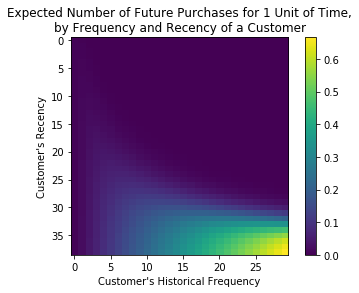

In [9]:
# Frequency/Recency Matrix
from lifetimes.plotting import plot_frequency_recency_matrix
plot_frequency_recency_matrix(bgf)

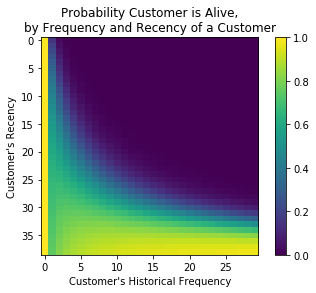

In [10]:
# 生存確率
from lifetimes.plotting import plot_probability_alive_matrix
plot_probability_alive_matrix(bgf)

In [14]:
# predeicted_purchases
# https://github.com/CamDavidsonPilon/lifetimes/blob/71d97ba52e1d730cda70b771038a3dc4c42f310a/lifetimes/fitters/beta_geo_fitter.py#L199
t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
display(data.sort_values(by='predicted_purchases').head(5))
display(data.sort_values(by='predicted_purchases').tail(5))

,frequency,recency,T,predicted_purchases
ID,,,,
1901,21,4.71,29.29,1.552359e-11
814,7,5.57,34.29,1.078224e-04
1166,4,1.29,32.71,2.738222e-04
244,5,5.14,37.29,4.447522e-04
310,4,4.29,37.00,9.218444e-04


,frequency,recency,T,predicted_purchases
ID,,,,
509,18,35.14,35.86,0.424877
841,19,34.00,34.14,0.474738
1981,17,28.43,28.86,0.486526
157,29,37.71,38.00,0.662396
1516,26,30.86,31.00,0.710623


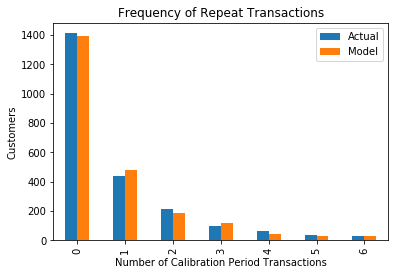

In [15]:
# モデル評価（ActualとModelが近ければ良い）
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [19]:
# 実際のデータから要約データやパラメータを抽出する方法
from lifetimes.datasets import load_transaction_data
from lifetimes.utils import summary_data_from_transaction_data

transaction_data = load_transaction_data()
display(transaction_data.head())

summary = summary_data_from_transaction_data(transaction_data, 'id', 'date', observation_period_end='2014-12-31')
display(summary.head())

display(bgf.fit(summary['frequency'], summary['recency'], summary['T']))

,date,id
0,2014-03-08 00:00:00,0
1,2014-05-21 00:00:00,1
2,2014-03-14 00:00:00,2
3,2014-04-09 00:00:00,2
4,2014-05-21 00:00:00,2


,frequency,recency,T
id,,,
0,0.0,0.0,298.0
1,0.0,0.0,224.0
2,6.0,142.0,292.0
3,0.0,0.0,147.0
4,2.0,9.0,183.0


<lifetimes.BetaGeoFitter: fitted with 5000 subjects, a: 1.85, alpha: 1.86, b: 3.18, r: 0.16>

,date,id
0,2014-03-08 00:00:00,0
1,2014-05-21 00:00:00,1
2,2014-03-14 00:00:00,2
3,2014-04-09 00:00:00,2
4,2014-05-21 00:00:00,2


,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
id,,,,,
0,0.0,0.0,177.0,0.0,121
1,0.0,0.0,103.0,0.0,121
2,6.0,142.0,171.0,0.0,121
3,0.0,0.0,26.0,0.0,121
4,2.0,9.0,62.0,0.0,121


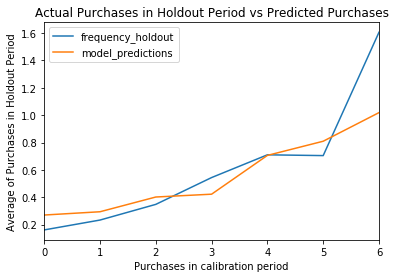

In [23]:
# calibrationデータとholdoutデータに分割して検証
# https://github.com/CamDavidsonPilon/lifetimes/blob/master/lifetimes/utils.py#L27
from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(transaction_data, 'id', 'date',
                                        calibration_period_end='2014-09-01',
                                        observation_period_end='2014-12-31' )
display(transaction_data.head())
display(summary_cal_holdout.head())

from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

In [43]:
# 将来購入予測
t = 10 #predict purchases in 10 periods
individual = summary.iloc[2]

# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_to_time`
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.010267394599192398

,date,id
81,2014-06-30 00:00:00,35
82,2014-07-03 00:00:00,35
83,2014-07-03 00:00:00,35
84,2014-07-12 00:00:00,35
85,2014-07-16 00:00:00,35
86,2014-07-17 00:00:00,35
87,2014-07-21 00:00:00,35
88,2014-08-01 00:00:00,35
89,2014-08-07 00:00:00,35
90,2014-09-07 00:00:00,35


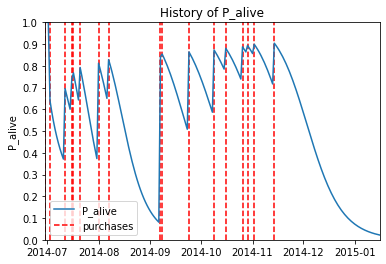

In [47]:
# 生存確率
from lifetimes.plotting import plot_history_alive

id = 35
days_since_birth = 200
sp_trans = transaction_data.loc[transaction_data['id'] == id]
display(sp_trans)
plot_history_alive(bgf, days_since_birth, sp_trans, 'date')

### Gamma-Gammaモデル

In [50]:
from lifetimes.datasets import load_cdnow_summary_data_with_monetary_value

summary_with_money_value = load_cdnow_summary_data_with_monetary_value()
display(summary_with_money_value.head())
returning_customers_summary = summary_with_money_value[summary_with_money_value['frequency']>0]

display(returning_customers_summary.head())

,frequency,recency,T,monetary_value
customer_id,,,,
1,2,30.43,38.86,22.35
2,1,1.71,38.86,11.77
3,0,0.00,38.86,0.00
4,0,0.00,38.86,0.00
5,0,0.00,38.86,0.00


,frequency,recency,T,monetary_value
customer_id,,,,
1,2,30.43,38.86,22.35
2,1,1.71,38.86,11.77
6,7,29.43,38.86,73.74
7,1,5.00,38.86,11.77
9,2,35.71,38.86,25.55


In [52]:
# Gamma-Gammaモデルは金銭的価値と購入頻度に相関がないことを仮定しているため、それを確認する必要がある
# （今回の場合はOK）
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.113884
frequency,0.113884,1.000000


In [53]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 946 subjects, p: 6.25, q: 3.74, v: 15.45>


In [66]:
display(ggf.conditional_expected_average_profit(
        summary_with_money_value['frequency'],
        summary_with_money_value['monetary_value']
    ).head(10))

print('Expected conditional average profit: {}, Average profit: {}'.format(
    ggf.conditional_expected_average_profit(
        summary_with_money_value['frequency'],
        summary_with_money_value['monetary_value']
    ).mean(),
    summary_with_money_value[summary_with_money_value['frequency']>0]['monetary_value'].mean()
))

customer_id
1     24.658616
2     18.911480
3     35.171002
4     35.171002
5     35.171002
6     71.462851
7     18.911480
8     35.171002
9     27.282408
10    35.171002
dtype: float64

Expected conditional average profit: 35.25295817605018, Average profit: 35.07855179704017
